In [1]:
from google import genai
from google.genai import types

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


In [3]:

class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!"
    "\n\n"
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

In [4]:
from langgraph.graph import StateGraph, START, END

# Try using different models. The Gemini 2.0 flash model is highly
# capable, great with tools, and has a generous free tier. If you
# try the older 1.5 models, note that the `pro` models are better at
# complex multi-tool cases like this, but the `flash` models are
# faster and have more free quota.
# Check out the features and quota differences here:
#  - https://ai.google.dev/gemini-api/docs/models/gemini
llm = "gemini-2.0-flash"


def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = StateGraph(OrderState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

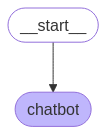

In [5]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

In [6]:
# add an human node to the graph
def human_node(state: OrderState) -> OrderState:
    """The human node. This is a placeholder for the human input."""
    # This is a placeholder. In a real application, this would be replaced
    # with a function that gets input from the user.
    user_input = input("User: ")
    state["messages"].append(user_input)
    return state | {"messages": [user_input]}

def mariachatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    if state["messages"]:
        new_output = llm.invoke(message_history)
        return {"messages": [new_output]}
    else:
        new_output = llm.invoke([WELCOME_MSG])
    return state | {"messages": [new_output]}

# start building the graph 
builder_graph = StateGraph(OrderState)
# add chatbot aand human node

builder_graph.add_node("chatbot", mariachatbot)
builder_graph.add_node("human", human_node)

# start with chatbot again.
builder_graph.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
builder_graph.add_edge("chatbot", "human");
        

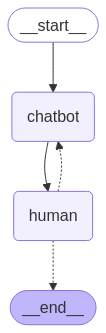

In [7]:
from typing import Literal


def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


builder_graph.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = builder_graph.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [8]:
from langchain_core.tools import tool

#define menu in hardcoded way
@tool
def get_menu() -> str:
    """Get the menu items."""
    return (
        "The menu includes:\n"
        "1. Espresso\n"
        "2. Americano\n"
        "3. Latte\n"
        "4. Cappuccino\n"
        "5. Mocha\n"
        "6. Macchiato\n"
        "7. Flat White\n"
        "8. Cold Brew\n"
        "9. Nitro Cold Brew\n"
        "10. Iced Coffee\n"
    )
# 

In [9]:
from langgraph.prebuilt import ToolNode

# Define the tools and create a "tools" node.
tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)

def maybe_route_to_tools(state: OrderState) -> str:
    """Route to the tools node if the user asks for the menu."""
    if not (msg:= state.get["messages"], [1]):
        raise ValueError(f"No message found in state when parsing state: {state}")
    # Only route based on the last message.
    msg = msg[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "chatbot"
    


AttributeError: 'str' object has no attribute 'bind_tools'

In [10]:
help(bind_tools)

NameError: name 'bind_tools' is not defined